In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

In [2]:
data =  pd.read_csv('./df_injury_player_data_features_v1.csv')
player = pd.read_csv('./player.csv',encoding='ISO-8859-1')
player_status = pd.read_csv('./player_stats.csv')
match = pd.read_csv('./match.csv')[['match_id','match_date','season']]
injuries = pd.read_csv('./injuries.csv', encoding='ISO-8859-1')


In [3]:
match = match.loc[match.match_date!='0000-00-00'] #remove erroneous data #only 1 row
match['start_year']= match['season'].str[:4].astype(int)
match['match_date']= pd.to_datetime(match['match_date'])
match = match.drop(columns='season')
match[:10]

match_id match_date  start_year
0         1 1992-08-15        1992
1         2 1992-08-15        1992
2         3 1992-08-15        1992
3         4 1992-08-15        1992
4         5 1992-08-15        1992
5         6 1992-08-15        1992
6         7 1992-08-15        1992
7         8 1992-08-15        1992
8         9 1992-08-15        1992
9        10 1992-08-16        1992

In [4]:
start_season = 2000
end_season = 2022
# injury_threshold = 120

In [5]:

player_status['substitution_on'] = player_status['substitution_on'].str.replace("'", "")
player_status['substitution_off'] = player_status['substitution_off'].str.replace("'", "")

def convert_minute(minute_str):
    if pd.isna(minute_str):
        return np.nan
    elif minute_str == 'Null':
        return np.nan
    elif '+' in minute_str:
        minute_str = minute_str.split('+')[1].strip()
        minute_int = int(minute_str) + 90
    else:
        minute_int = int(minute_str)
    return minute_int


player_status['substitution_on'] = player_status['substitution_on'].apply(convert_minute)
player_status['substitution_off'] = player_status['substitution_off'].apply(convert_minute)

In [6]:
#Merge player_stats to get player_name
player['p_id2'] = player['player_name'].str.lower().str.replace(' ', '')

player1 = pd.merge(player_status,player[['p_id2', 'player_name', 'position', 'player_id']], on='player_id', how='left')

#Merge player1 with match table to get date of each game played
player2 = pd.merge(player1, match, on ='match_id', how = 'left')


In [7]:
#Filter between seasons we are analysing
player2 = player2.loc[player2.start_year.between(start_season, end_season)]


In [8]:
def calculate_minutes_played(row):
    if row['is_in_starting_11'] == 1 and pd.isnull(row['substitution_off']):
        return 95 #Average of 5 additional minutes
    elif row['is_in_starting_11'] == 1 and pd.notnull(row['substitution_off']):
        return row['substitution_off']
    elif row['is_in_starting_11'] == 0 and pd.isnull(row['substitution_on']):
        return 0
    elif row['is_in_starting_11'] == 0 and pd.notnull(row['substitution_on']) and pd.isnull(row['substitution_off']):
        return 95 - row['substitution_on']
    elif row['is_in_starting_11'] == 0 and pd.notnull(row['substitution_on']) and pd.notnull(row['substitution_off']):
        return row['substitution_off'] - row['substitution_on']

player2['minutes_played'] = player2.apply(calculate_minutes_played, axis=1)

#Create game_played column which is 1 if minutes_played is more than 0
player2['game_played'] = player2['minutes_played'].apply(lambda x: 1 if x > 0 else 0)

#change negative values to 0
player2['minutes_played'] = player2['minutes_played'].apply(lambda x: 0 if x < 0 else x)

#Take relevant columns
player3 = player2[['p_id2', 'position' ,'match_id','match_date', 'start_year','minutes_played','game_played']]

In [9]:
# Remove non-alphabetic characters and convert to lowercase
injuries['p_id2'] = injuries['player_name'].replace('[^a-zA-Z]+', '', regex=True).str.lower()

#remove nulls
injuries = injuries.loc[injuries['season_injured'].notna()]

#add start_year column
injuries['start_year'] = ('20' + injuries['season_injured'].str[:2]).astype(int)

# Define a function to extract integers from the duration column
def extract_duration(row):
    duration_str = row['duration']
    match = re.search(r'\d+', duration_str)
    if match:
        return int(match.group())
    else:
        return 0
# Apply the function to create a new column with integer values
injuries['duration'] = injuries.apply(extract_duration, axis=1)

#Remove injuries which are sicknesses
injuries = injuries.loc[~injuries.injury.isin(['Corona virus', 'Ill', 'Cold','Food Poisoning', 'Quarantine'])]

#Filter only injuries between start and end year

injuries = injuries.loc[injuries.start_year.between(start_season,end_season)]

#take relevant columns
injuries = injuries[['p_id2','start_year', 'injury',
       'injured_since', 'injured_until', 'duration']]

In [10]:
# Grouping player_dataframe by player_id
# group by p_id2 and start_year and aggregate by summing minutes_played and counting number of rows
injuries_grouped = injuries.groupby(['p_id2', 'start_year']).agg({'duration': 'sum'})

# rename the columns and reset index
injuries_grouped = injuries_grouped.rename(columns={'duration': 'season_days_injured'})
injuries_grouped = injuries_grouped.reset_index()

# create total minutes played column
total_days_injured = injuries.groupby('p_id2').agg({'duration': 'sum'}).rename(
    columns={'duration': 'total_days_injured'})

# merge the total minutes and games played columns with the grouped dataframe
injuries_grouped = injuries_grouped.merge(total_days_injured, on='p_id2')
df_injuries = injuries_grouped
df_injuries

p_id2  start_year  season_days_injured  total_days_injured
0         aaronconnolly        2018                   77                 164
1         aaronconnolly        2019                   13                 164
2         aaronconnolly        2020                   71                 164
3         aaronconnolly        2022                    3                 164
4        aaroncresswell        2016                   95                 226
...                 ...         ...                  ...                 ...
6014  zlatanibrahimovic        2018                   36                1172
6015  zlatanibrahimovic        2019                   39                1172
6016  zlatanibrahimovic        2020                  210                1172
6017  zlatanibrahimovic        2021                  112                1172
6018  zlatanibrahimovic        2022                  306                1172

[6019 rows x 4 columns]

In [11]:
fifa_15 = pd.read_csv('archive/players_15.csv')
fifa_16 = pd.read_csv('archive/players_16.csv')
fifa_17 = pd.read_csv('archive/players_17.csv')
fifa_18 = pd.read_csv('archive/players_18.csv')
fifa_19 = pd.read_csv('archive/players_19.csv')
fifa_20 = pd.read_csv('archive/players_20.csv')
fifa_21 = pd.read_csv('archive/players_21.csv')
fifa_22 = pd.read_csv('archive/players_22.csv')

/var/folders/75/l6tgbsfn4zdgxs_ktw74zkgw0000gn/T/ipykernel_27644/769123066.py:1: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa_15 = pd.read_csv('archive/players_15.csv')
/var/folders/75/l6tgbsfn4zdgxs_ktw74zkgw0000gn/T/ipykernel_27644/769123066.py:2: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa_16 = pd.read_csv('archive/players_16.csv')
/var/folders/75/l6tgbsfn4zdgxs_ktw74zkgw0000gn/T/ipykernel_27644/769123066.py:4: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa_18 = pd.read_csv('archive/players_18.csv')
/var/folders/75/l6tgbsfn4zdgxs_ktw74zkgw0000gn/T/ipykernel_27644/769123066.py:8: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa_22 = pd.read_csv('archive/players_22.csv')


In [12]:
def extract_name_url(df):
    # Copy the original DataFrame to avoid modifying it directly
    new_df = df.copy()

    # Extract the name from the player_url using a regular expression
    pattern = r'/player/\d+/(.*)/'
    new_df['p_id2'] = df['player_url'].apply(lambda x: re.findall(pattern, x)[0])

    # Remove any non-alphabetic characters and convert to lowercase
    new_df['p_id2'] = new_df['p_id2'].apply(lambda x: re.sub('[^a-zA-Z]', '', x.lower()))

    return new_df

#Function to apply extract_name_url and take relevant columns

def clean_fifa_data(df):

    #Filter relevant columns only
    relevant_cols = ['sofifa_id', 'player_url', 'dob', 'height_cm', 'weight_kg', 'nationality_name', 'work_rate',
                    'pace', 'physic', 'overall']
    df = df[relevant_cols]
    df = extract_name_url(df)
    return df

In [13]:
fifa_15 = clean_fifa_data(fifa_15)
fifa_16 = clean_fifa_data(fifa_16)
fifa_17 = clean_fifa_data(fifa_17)
fifa_18 = clean_fifa_data(fifa_18)
fifa_19 = clean_fifa_data(fifa_19)
fifa_20 = clean_fifa_data(fifa_20)
fifa_21 = clean_fifa_data(fifa_21)
fifa_22 = clean_fifa_data(fifa_22)

In [14]:
# Concatenate all the dataframes into a single dataframe
fifa_all = pd.concat([fifa_15 ,fifa_16, fifa_17, fifa_18, fifa_19, fifa_20, fifa_21,fifa_22])

# Group the concatenated dataframe by sofifa_id
grouped = fifa_all.groupby('sofifa_id')

# Compute the mean of float/int columns and the mode of non-numeric columns for each group
aggregated = grouped.agg(lambda x: x.mean() if x.dtype=='float64' or x.dtype=='int64' else x.mode()[0])

# Create a new dataframe called 'fifa' using the aggregated data
fifa = pd.DataFrame(aggregated.to_records())

# Rename columns as needed
fifa = fifa.rename(columns={'index': 'sofifa_id', 'overall': 'fifa_rating'})

#take only relevant columns
fifa = fifa[['p_id2','dob', 'height_cm', 'weight_kg',
       'nationality_name', 'work_rate', 'pace', 'physic', 'fifa_rating']]

In [15]:
print('Unique players in player dataframe:',player3.p_id2.nunique())
print('Unique players in injury dataframe:',df_injuries.p_id2.nunique())
print('Unique players in FIFA dataframe:', fifa.p_id2.nunique())

Unique players in player dataframe: 3839
Unique players in injury dataframe: 1414
Unique players in FIFA dataframe: 44991


In [16]:
# List of players to be included in our analysis
player_list = injuries['p_id2'].tolist()

#Filter player and fifa dataframes to include relevant player_list
player4 = player3.loc[player3.p_id2.isin(player_list)]
fifa2 = fifa.loc[fifa.p_id2.isin(player_list)]

print('Unique players on all 3 datasets:',pd.merge(
    player4,injuries, on='p_id2' ,how = 'inner').merge(fifa2, on = 'p_id2', how = 'inner').p_id2.nunique())

Unique players on all 3 datasets: 882


In [17]:
# List of players to be included in our analysis
player_list = injuries['p_id2'].tolist()

#Filter player and fifa dataframes to include relevant player_list
player4 = player3.loc[player3.p_id2.isin(player_list)]
fifa2 = fifa.loc[fifa.p_id2.isin(player_list)]

print('Unique players on all 3 datasets:',pd.merge(
    player4,injuries, on='p_id2' ,how = 'inner').merge(fifa2, on = 'p_id2', how = 'inner').p_id2.nunique())

Unique players on all 3 datasets: 882


In [18]:
# Grouping player_dataframe by player_id
# group by p_id2 and start_year and aggregate by summing minutes_played and counting number of rows
grouped = player4.groupby(['p_id2', 'start_year']).agg({'minutes_played': 'sum', 'game_played': 'sum', 'match_id': 'count'})
# rename the columns
grouped = grouped.rename(columns={
    'minutes_played': 'season_minutes_played', 'game_played': 'season_games_played', 'match_id':'season_matches_in_squad'})
# reset the index
grouped = grouped.reset_index()
# create total minutes played column
total_minutes_played = player4.groupby('p_id2').agg({'minutes_played': 'sum'}).rename(
    columns={'minutes_played': 'total_minutes_played'})
# create total games played column
total_games_played = player4.groupby('p_id2').agg({'game_played': 'sum'}).rename(columns={'game_played': 'total_games_played'})
# merge the total minutes and games played columns with the grouped dataframe
grouped = grouped.merge(total_minutes_played, on='p_id2').merge(total_games_played, on='p_id2')
# Group by p_id2 and start_year
grouped2 = player4.groupby(['p_id2', 'start_year'])
df_playtime = grouped

In [19]:
#Merge relevant dataframes
df1 = df_injuries.merge(df_playtime, on = ['p_id2', 'start_year'], how= 'inner')
df2 = df1.merge(fifa, on ='p_id2', how = 'inner')

#Add column for position
df = df2.merge(player[['p_id2', 'position']], on = 'p_id2', how = 'inner')

print('Final number of players to be analyzed:',df.p_id2.nunique())


Final number of players to be analyzed: 683


In [20]:
df.reset_index(drop=True, inplace=True)  # First reset index

# Calculate age at the beginning of the season
df['age'] = df['start_year'] - df['dob'].str[:4].astype(int)

# Custom function to calculate cumulative minutes and games played
def calculate_cumulative(x):
    return x.shift(1).expanding().sum()

# Calculate cumulative minutes and games played prior to the current season
df['cumulative_minutes_played'] = df.groupby('p_id2')['season_minutes_played'].apply(calculate_cumulative).reset_index(level=0, drop=True)
df['cumulative_games_played'] = df.groupby('p_id2')['season_games_played'].apply(calculate_cumulative).reset_index(level=0, drop=True)

# Calculate minutes per game in all previous seasons
df['minutes_per_game_prev_seasons'] = df['cumulative_minutes_played'] / df['cumulative_games_played']

# Custom function to calculate average over previous seasons
def calculate_average(x):
    return x.shift(1).expanding().mean()

# Calculate average days injured per season in prior seasons
df['avg_days_injured_prev_seasons'] = df.groupby('p_id2')['season_days_injured'].apply(calculate_average).reset_index(level=0, drop=True)

# Calculate average games per season in previous seasons
df['avg_games_per_season_prev_seasons'] = df.groupby('p_id2')['season_games_played'].apply(calculate_average).reset_index(level=0, drop=True)

# Calculate the Body Mass Index (BMI)
df['bmi'] = df['weight_kg'] / (df['height_cm'] / 100) ** 2

# Map work rate to numeric values (low = 1, medium = 1.5, high = 2)
work_rate_map = {'Low': 1, 'Medium': 1.5, 'High': 2}
df['work_rate_numeric'] = df['work_rate'].apply(lambda x: sum([work_rate_map[w] for w in x.split('/')]))

# Map position to numeric values where 0 = Goalkeeper, 1 = Defender, 2 = Forward, 3 = Midfielder
pos_order = {'Goalkeeper': 0, 'Defender': 1, 'Forward': 2, 'Midfielder': 3}
df['position_numeric'] = df['position'].map(pos_order)

# Define injury threshold for significant injury
injury_threshold = 30

# Create a feature indicating if the player had a significant injury in the previous season
prev_season_injury = df.groupby('p_id2')['season_days_injured'].shift(1)
df['significant_injury_prev_season'] = np.where(prev_season_injury.isna(), np.nan, (prev_season_injury >= injury_threshold).astype(int))

# Calculate cumulative days injured across all previous seasons and add a lag for days injured in the prior season
df['cumulative_days_injured'] = df.groupby('p_id2')['total_days_injured'].apply(calculate_cumulative).reset_index(level=0, drop=True)
df['season_days_injured_prev_season'] = df.groupby('p_id2')['season_days_injured'].shift(1)

# Replace infinite values with NaN, if they appear in any division or transformation
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [21]:
df.to_csv('df_injury_player_data_features_v1.csv', index = False)


In [22]:
df = pd.read_csv('df_injury_player_data_features_v1.csv')
physical_features = ['p_id2', 'start_year', 'position', 'age',
                     'bmi', 'height_cm', 'weight_kg', 'work_rate_numeric' ,'pace', 'physic',
                     'work_rate', 'position_numeric' ,'season_days_injured']

season_features = ['p_id2', 'start_year', 'cumulative_minutes_played','cumulative_games_played',
                   'minutes_per_game_prev_seasons','avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons',
                  'significant_injury_prev_season', 'cumulative_days_injured','season_days_injured_prev_season',
                   'season_days_injured']

df_physical = df[physical_features]
df_season = df[season_features]

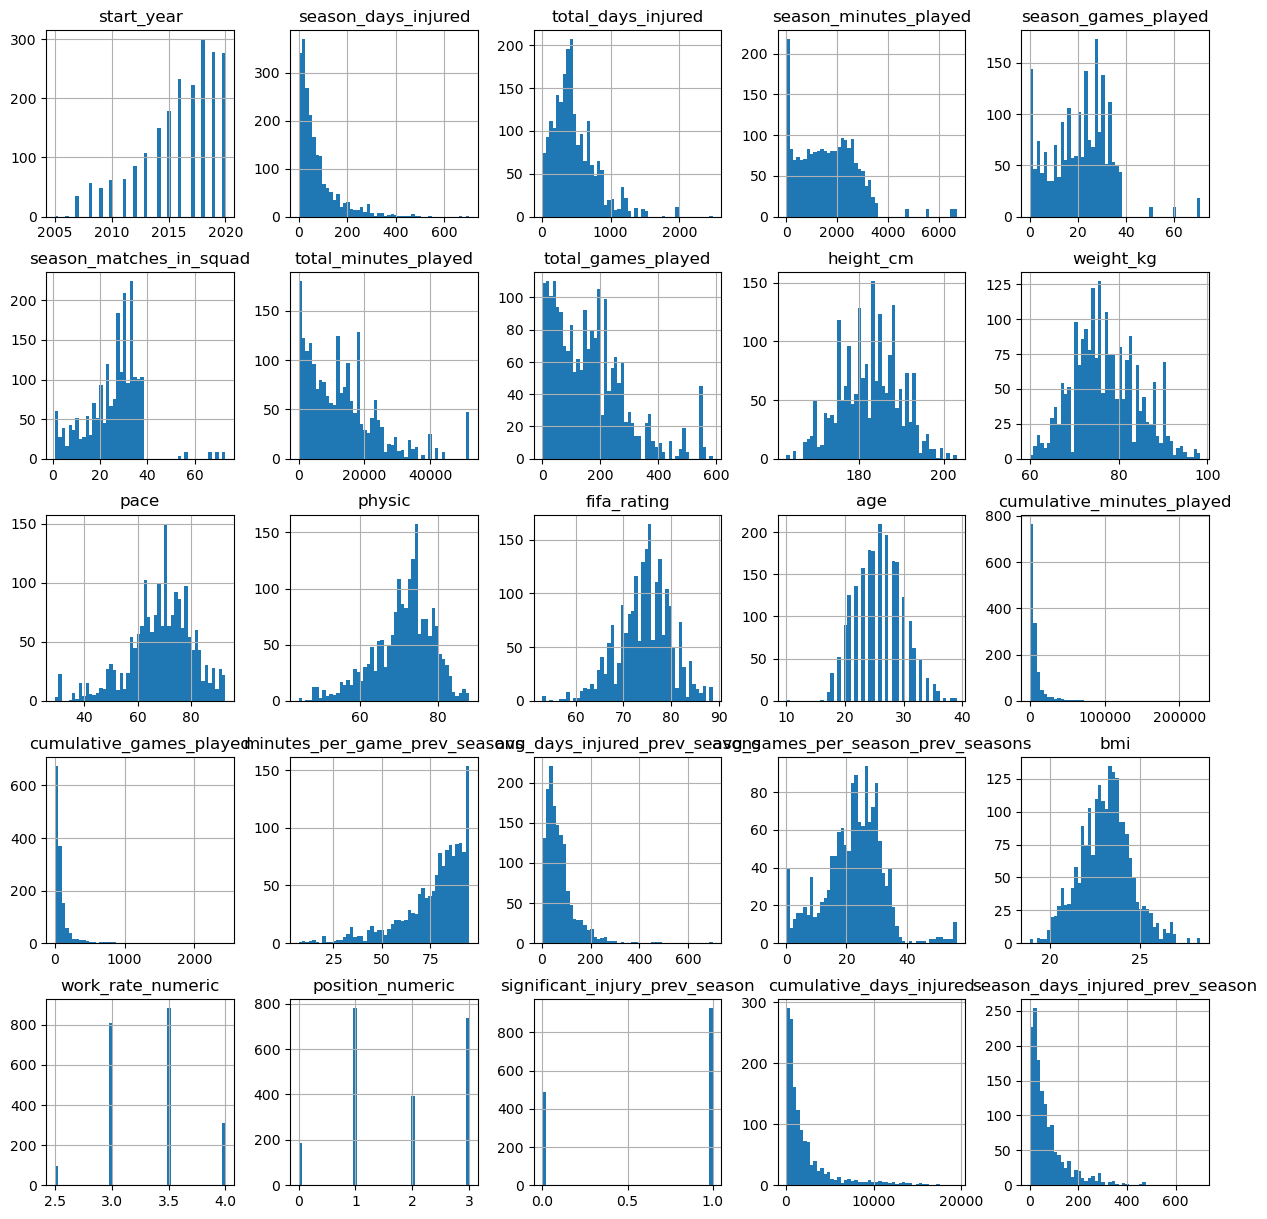

In [23]:
_ = df[df.columns].hist(bins=50, figsize=(15, 15))

In [24]:
def plot_features_vs_target(df, x_features, y_feature):
    df_nonulls = df.dropna()

    # Generate line plots for each numerical column against the target feature
    plt.figure(figsize=(15, 25))
    for i, column in enumerate(x_features, 1):
        plt.subplot(5, 3, i)
        plt.plot(df_nonulls[column], df_nonulls[y_feature], marker='o', linestyle='', alpha=0.5)

        # Fit a line to the data
        m, b = np.polyfit(df_nonulls[column], df_nonulls[y_feature], 1)
        plt.plot(df_nonulls[column], m * df_nonulls[column] + b, color='r', linestyle='-', linewidth=2)

        # Calculate the R-squared value and correlation coefficient
        slope, intercept, r_value, p_value, std_err = linregress(df_nonulls[column], df_nonulls[y_feature])
        r_squared = r_value**2
        corr_coef, _ = pearsonr(df_nonulls[column], df_nonulls[y_feature])

        # Add R-squared value and correlation coefficient to the plot
        plt.text(0.05, 0.95, f'R^2: {r_squared:.2f}', transform=plt.gca().transAxes)
        plt.text(0.05, 0.90, f'Correlation: {corr_coef:.2f}', transform=plt.gca().transAxes)

        plt.xlabel(column)
        plt.ylabel(y_feature)

    plt.tight_layout()
    plt.show()

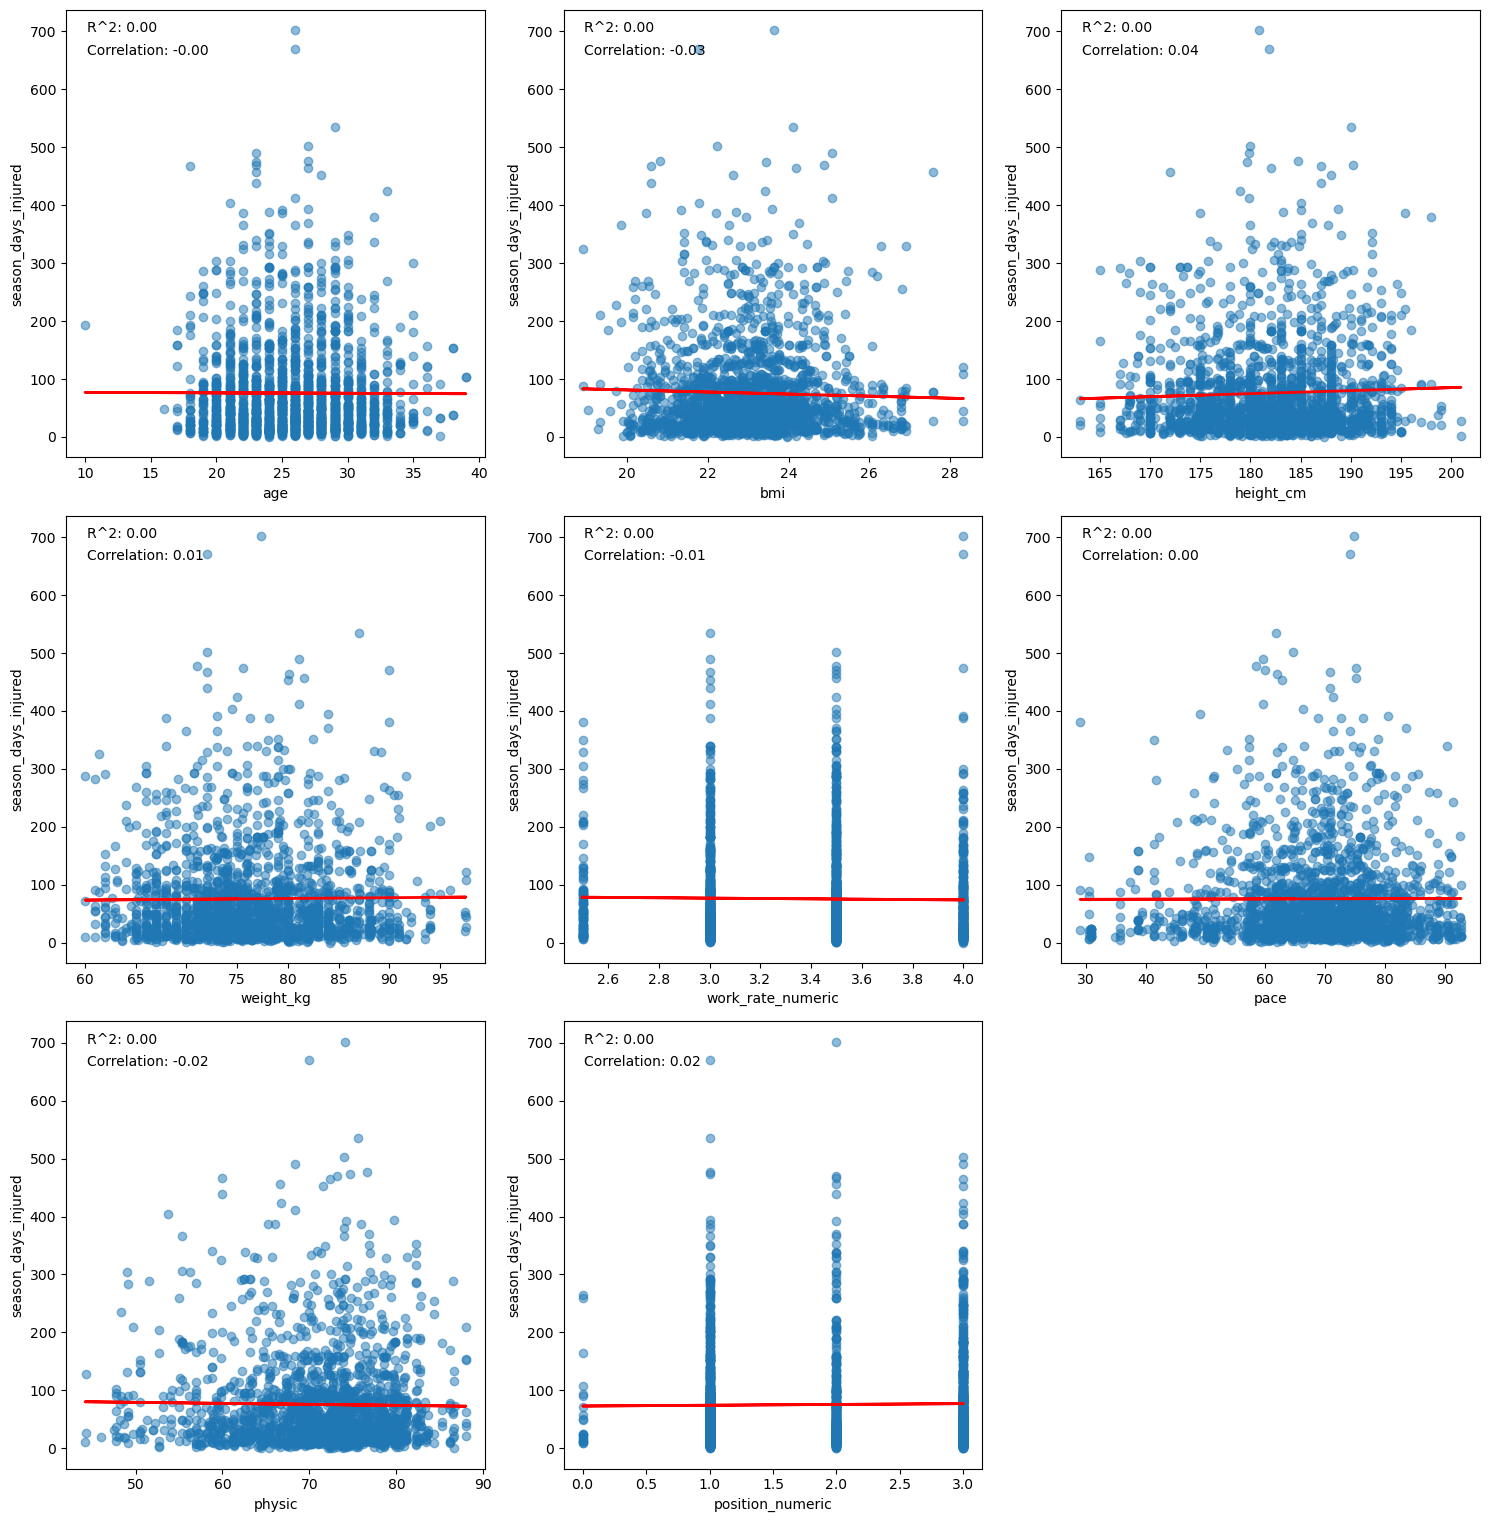

In [25]:
physical_features = ['age','bmi', 'height_cm', 'weight_kg', 'work_rate_numeric' ,'pace', 'physic',
                     'position_numeric']

plot_features_vs_target(df_physical, physical_features, 'season_days_injured')

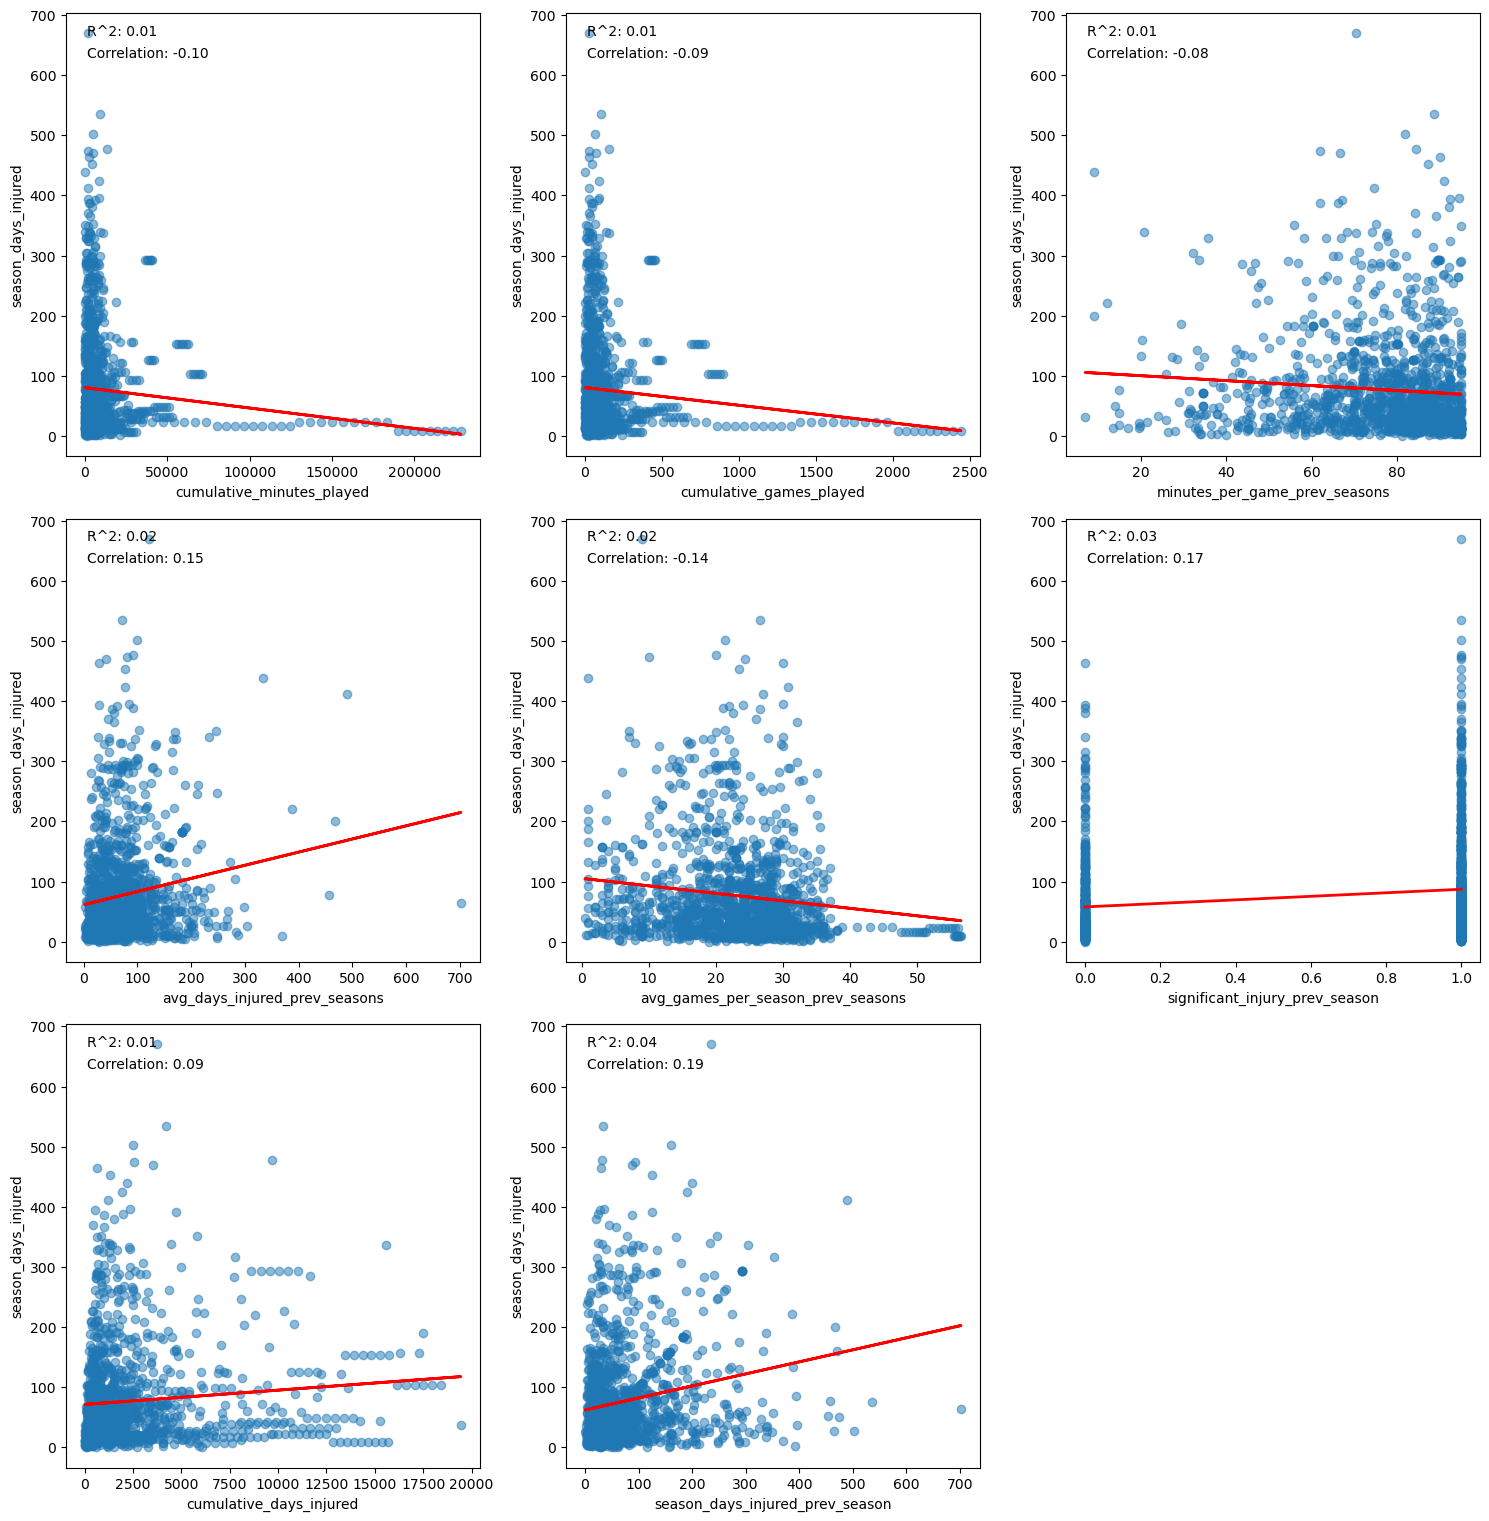

In [26]:
season_features = ['cumulative_minutes_played','cumulative_games_played',
                   'minutes_per_game_prev_seasons','avg_days_injured_prev_seasons', 'avg_games_per_season_prev_seasons',
                  'significant_injury_prev_season', 'cumulative_days_injured','season_days_injured_prev_season']

plot_features_vs_target(df_season, season_features, 'season_days_injured')

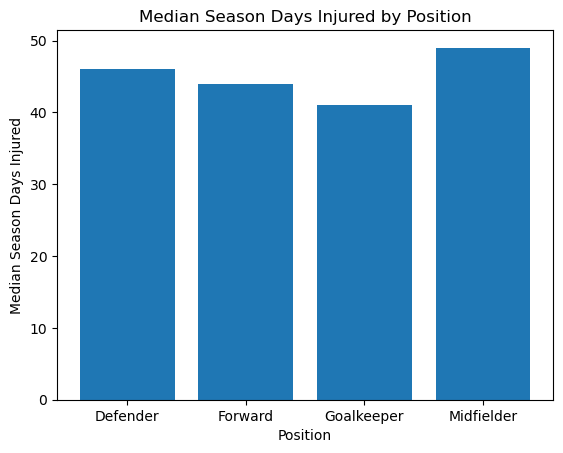

In [27]:
# See if/how position affects injury

grouped = df.groupby('position')['season_days_injured'].median()

plt.bar(grouped.index, grouped.values)
plt.title('Median Season Days Injured by Position')
plt.xlabel('Position')
plt.ylabel('Median Season Days Injured')
plt.show()

In [28]:
def calculate_threshold_percentages(df, column_name, threshold_range):
    percentages = []
    for threshold in threshold_range:
        percentage_above_threshold = (df[column_name] > threshold).mean()
        percentages.append(percentage_above_threshold)
    return percentages
# Define the threshold range
threshold_range = np.arange(0, 210, 10)
# Call the function to calculate the percentages
percentages = calculate_threshold_percentages(df, 'season_days_injured', threshold_range)

# Print the percentages
for threshold, percentage in zip(threshold_range, percentages):
    print(f'{threshold:.1f}: {percentage:.2%}')

0.0: 99.95%
10.0: 90.95%
20.0: 77.43%
30.0: 64.43%
40.0: 55.10%
50.0: 46.76%
60.0: 40.86%
70.0: 35.43%
80.0: 31.00%
90.0: 26.29%
100.0: 22.62%
110.0: 20.24%
120.0: 18.86%
130.0: 16.43%
140.0: 14.76%
150.0: 14.05%
160.0: 11.90%
170.0: 10.81%
180.0: 10.19%
190.0: 9.00%
200.0: 8.33%


In [29]:
#injury_threshold defined in beginning of notebook
df['target_major_injury'] = (df['season_days_injured'] > injury_threshold).astype('category')

In [30]:

#Distribution of our target categorical variable
df['target_major_injury'].value_counts()

target_major_injury
True     1353
False     747
Name: count, dtype: int64

In [31]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = df[df['target_major_injury'] == False]  
minority_class = df[df['target_major_injury'] == True]   

# Upsample the majority class to match the size of the minority class
majority_upsampled = resample(majority_class,
                              replace=True,  # Sample with replacement
                              n_samples=1345,  # Match size of minority class
                              random_state=42)  # For reproducibility

# Combine the upsampled majority class with the minority class
df_balanced = pd.concat([minority_class, majority_upsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the number of samples in each class
print("Class distribution after balancing:")
print(df_balanced['target_major_injury'].value_counts())


Class distribution after balancing:
target_major_injury
True     1353
False    1345
Name: count, dtype: int64


In [32]:
#Drop nulls in key columns
cols_to_drop_nulls = [
    'cumulative_minutes_played', 'minutes_per_game_prev_seasons',
    'avg_days_injured_prev_seasons', 'significant_injury_prev_season',
    'cumulative_days_injured'
]

df = df.dropna(subset=cols_to_drop_nulls)

#Impute other nulls with mean (there are not many null values in pace/physic/position)
from sklearn.impute import SimpleImputer
mean_imputer = SimpleImputer(strategy='mean')
df[['pace', 'physic']] = mean_imputer.fit_transform(df[['pace', 'physic']])

mode_imputer = SimpleImputer(strategy='most_frequent')
df['position_numeric'] = mode_imputer.fit_transform(df['position_numeric'].values.reshape(-1, 1))
#Dataset for Y as a categorical variable
df_model_cat = df[['p_id2', 'start_year', 'height_cm', 'weight_kg', 'work_rate_numeric', 'pace',
       'physic', 'position_numeric', 'age', 'cumulative_minutes_played','minutes_per_game_prev_seasons',
       'avg_days_injured_prev_seasons', 'significant_injury_prev_season', 'cumulative_days_injured',
               'target_major_injury' ]]

#Dataset for Y as a numerical variable
df_model_num = df[['p_id2', 'start_year', 'height_cm', 'weight_kg', 'work_rate_numeric', 'pace',
       'physic', 'position_numeric', 'age', 'cumulative_minutes_played','minutes_per_game_prev_seasons',
       'avg_days_injured_prev_seasons', 'significant_injury_prev_season', 'cumulative_days_injured',
                   'season_days_injured']]
print('Total rows:', df_model_cat.shape[0])


Total rows: 1393


In [33]:
from sklearn.model_selection import train_test_split

X = df_model_cat.drop(['target_major_injury', 'p_id2', 'start_year'], axis=1)
y = df_model_cat['target_major_injury']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

df_model_cat['target_major_injury']

print(df_model_cat['target_major_injury']==True)

1        True
3        True
4        True
5       False
7        True
        ...  
2091    False
2092    False
2093     True
2095     True
2099     True
Name: target_major_injury, Length: 1393, dtype: bool


In [34]:
from sklearn.preprocessing import StandardScaler

X_train_scaled = X_train.copy() #Maintain an unscaled copy (for us to use in XG Boost Feature Selection later)
X_test_scaled = X_test.copy() #Maintain an unscaled copy (for us to use in XG Boost Feature Selection later)

scaler = StandardScaler()

continuous_features = [
    'height_cm', 'weight_kg', 'work_rate_numeric', 'pace', 'physic',
    'age', 'cumulative_minutes_played', 'minutes_per_game_prev_seasons',
    'avg_days_injured_prev_seasons', 'cumulative_days_injured'
]

X_train_scaled[continuous_features] = scaler.fit_transform(X_train_scaled[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test_scaled[continuous_features])

In [35]:
# Convert target variable to integer
y_train = y_train.astype(int)
y_test = y_test.astype(int)


from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

base_estimator = LogisticRegression(random_state=42)

rfe = RFECV(base_estimator, step=1, cv=5, scoring='roc_auc')
rfe.fit(X_train_scaled, y_train)

selected_features = X_train_scaled.columns[rfe.support_]

X_train_rfe_scaled = rfe.transform(X_train_scaled)
X_test_rfe_scaled = rfe.transform(X_test_scaled)

In [36]:
#See final selected features
selected_features = X_train_scaled.columns[rfe.support_]
print("Selected features:", selected_features)

Selected features: Index(['cumulative_minutes_played', 'significant_injury_prev_season',
       'cumulative_days_injured'],
      dtype='object')


In [37]:
# Fit  base estimator with  selected features
base_estimator.fit(X_train_rfe_scaled, y_train)

# Extract  feature importance scores
if hasattr(base_estimator, "coef_"):
    feature_importance_scores = base_estimator.coef_[0]
elif hasattr(base_estimator, "feature_importances_"):
    feature_importance_scores = base_estimator.feature_importances_

print("Feature importance scores:", dict(zip(selected_features, feature_importance_scores)))

Feature importance scores: {'cumulative_minutes_played': -1.6559900767343596, 'significant_injury_prev_season': 0.5362162839209363, 'cumulative_days_injured': 1.2137658296026013}


In [38]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)

model.fit(X_train_rfe_scaled, y_train)

LogisticRegression(random_state=42)

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_test_rfe_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.7033492822966507
Precision: 0.7191977077363897
Recall: 0.9061371841155235
F1 Score: 0.8019169329073482
ROC AUC Score: 0.6055508615613079


In [40]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False , eval_metric='auc'
)

# Fit the model to the training data
xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC score:", roc_auc)

ROC AUC score: 0.6985175512712191


/Users/samsamaei/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


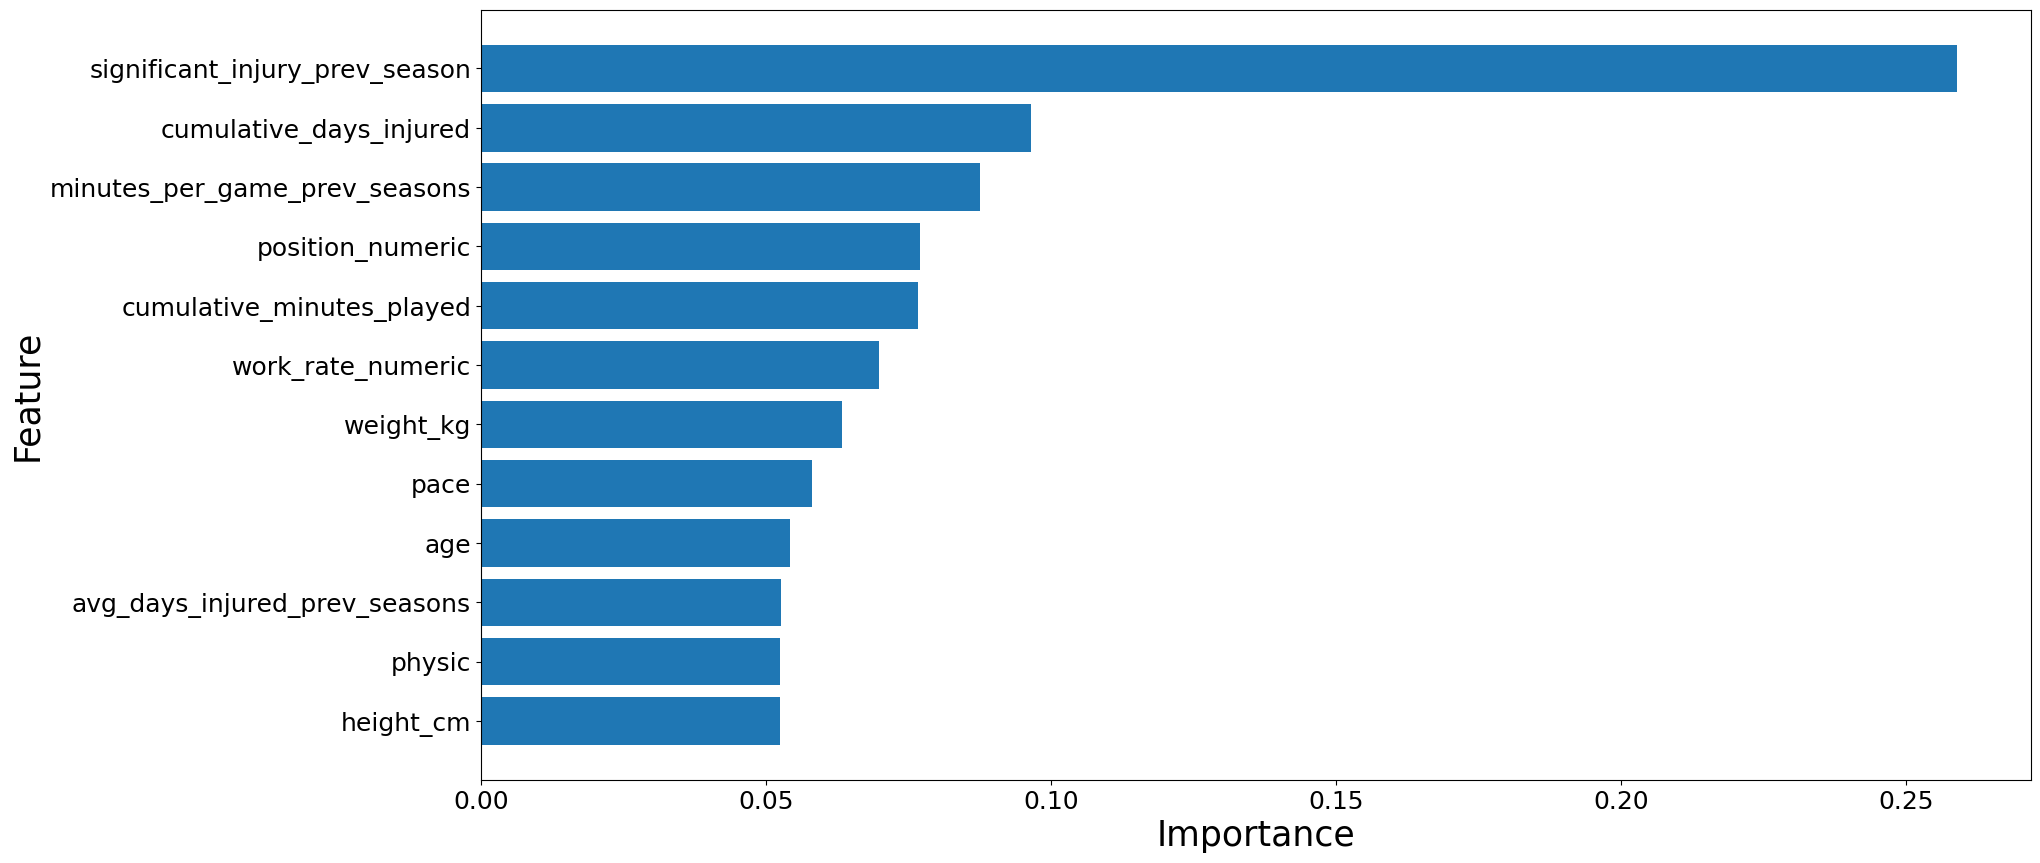

In [41]:
# Extract feature importances
importances = xgb_clf.feature_importances_

# Create dictionary of feature importances
importances_dict = dict(zip(X_train.columns, importances))

# Sort dictionary by descending importance
importances_dict_sorted = dict(sorted(importances_dict.items(), key=lambda item: item[1]))

# Set font size
plt.rcParams.update({'font.size': 10})

# Plot feature importances
plt.figure(figsize=(20, 10))
plt.barh(list(importances_dict_sorted.keys()), list(importances_dict_sorted.values()))
plt.xlabel("Importance", fontsize=25)
plt.ylabel("Feature", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

# Encode labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create XGBClassifier with eval_metric
base_estimator = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# Recursive Feature Elimination with Cross-Validation (RFECV)
rfe = RFECV(base_estimator, step=1, cv=5, scoring='roc_auc')
rfe.fit(X_train, y_train_encoded)

# Get selected features and transform the datasets
selected_features = X_train.columns[rfe.support_]
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Display selected features
print("Selected features:", selected_features)


Selected features: Index(['height_cm', 'weight_kg', 'pace', 'age', 'cumulative_minutes_played',
       'minutes_per_game_prev_seasons', 'avg_days_injured_prev_seasons',
       'significant_injury_prev_season', 'cumulative_days_injured'],
      dtype='object')


In [43]:
# Fit  base estimator with  selected features
base_estimator.fit(X_train_rfe, y_train)

# Extract  feature importance scores
if hasattr(base_estimator, "coef_"):
    feature_importance_scores = base_estimator.coef_[0]
elif hasattr(base_estimator, "feature_importances_"):
    feature_importance_scores = base_estimator.feature_importances_

print("Feature importance scores:", dict(zip(selected_features, feature_importance_scores)))

Feature importance scores: {'height_cm': 0.08359577, 'weight_kg': 0.09313917, 'pace': 0.086042985, 'age': 0.09237725, 'cumulative_minutes_played': 0.10735017, 'minutes_per_game_prev_seasons': 0.100350976, 'avg_days_injured_prev_seasons': 0.08110449, 'significant_injury_prev_season': 0.23038842, 'cumulative_days_injured': 0.12565076}


In [44]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    use_label_encoder=False,
    booster='gbtree',
    eval_metric='auc'
)

# Fit the model to the training data
xgb_clf.fit(X_train_rfe, y_train)

# Make predictions on the test set
y_pred_proba = xgb_clf.predict_proba(X_test_rfe)[:, 1]
y_pred = xgb_clf.predict(X_test_rfe)  # Convert probabilities to class predictions

# Compute metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Accuracy: 0.7272727272727273
Precision: 0.7570977917981072
Recall: 0.8664259927797834
F1 Score: 0.8080808080808081
ROC AUC Score: 0.7318534449650511


/Users/samsamaei/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:40:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [52]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],  # Added larger values
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],  # Added more granularity
    'max_depth': [3, 4, 5, 6, 7],  # Added deeper trees
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Added lower subsample rates
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # More variety in feature sampling
    'min_child_weight': [1, 2, 3, 4, 5, 6],  # Added finer granularity
    'reg_alpha': [0, 0.1, 0.5, 1, 2],  # Increased range for L1 regularization
    'reg_lambda': [0.5, 1, 2, 3, 5],  # Increased range for L2 regularization
    'gamma': [0, 0.1, 0.3, 0.5, 1],  # Added gamma for minimum loss reduction
    'scale_pos_weight': [1, 2, 5, 10]  # Added for handling class imbalance
}

xgb_clf = XGBClassifier(random_state=42, eval_metric='auc')
# Handle imbalanced data with SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smotetomek.fit_resample(X_train_scaled, y_train_encoded)


random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_distributions,
    n_iter=100,  # Increased number of iterations for more combinations
    scoring='roc_auc',
    cv=5,  # 5-fold cross-validation for robust evaluation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores for faster computation
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Extract and display the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.7, 'scale_pos_weight': 10, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


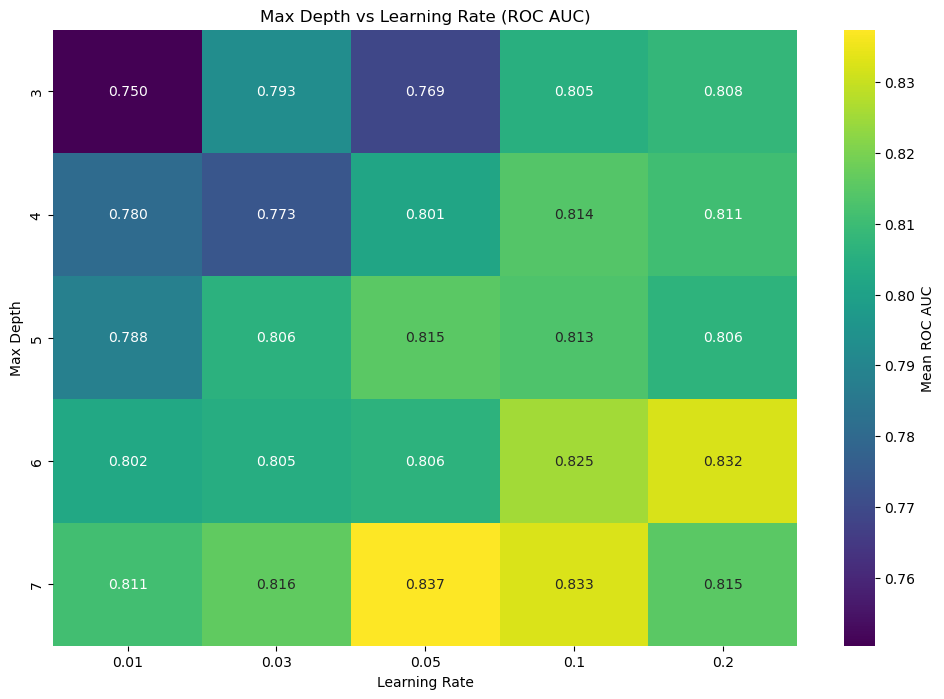

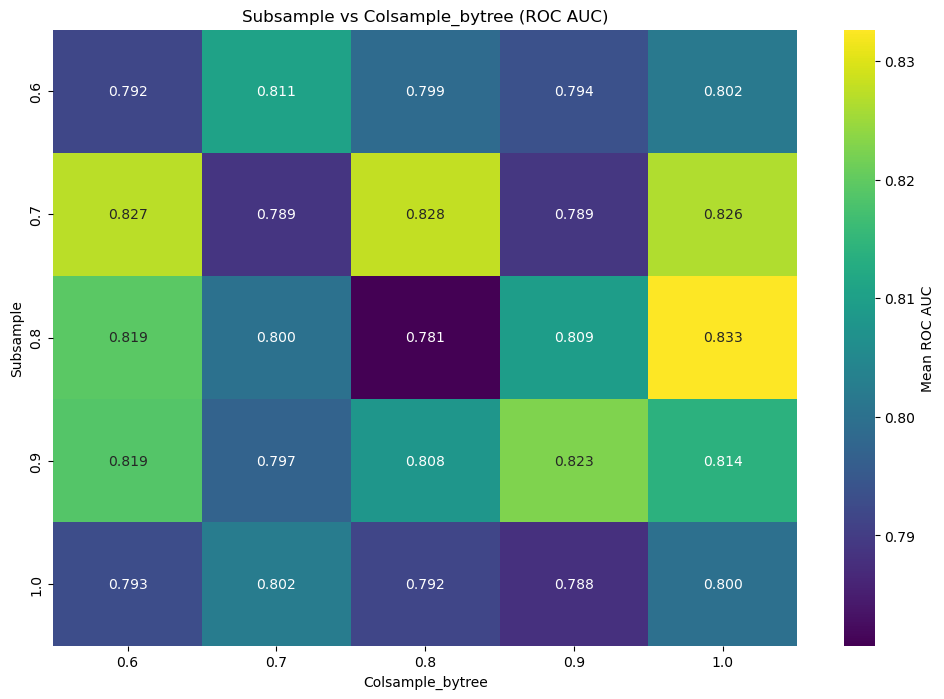

In [54]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert RandomizedSearchCV results to a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Example 1: Heatmap for 'max_depth' and 'learning_rate'
heatmap_data = results.pivot_table(
    index='param_max_depth',
    columns='param_learning_rate',
    values='mean_test_score'
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean ROC AUC'})
plt.title('Max Depth vs Learning Rate (ROC AUC)')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.show()

# Example 2: Heatmap for 'subsample' and 'colsample_bytree'
heatmap_data2 = results.pivot_table(
    index='param_subsample',
    columns='param_colsample_bytree',
    values='mean_test_score'
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data2, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean ROC AUC'})
plt.title('Subsample vs Colsample_bytree (ROC AUC)')
plt.xlabel('Colsample_bytree')
plt.ylabel('Subsample')
plt.show()


In [56]:
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_rfe)
X_test_scaled = scaler.transform(X_test_rfe)

# Handle imbalanced data with SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smotetomek.fit_resample(X_train_scaled, y_train_encoded)

# Train final model with the best hyperparameters
final_xgb_clf = XGBClassifier(
    subsample=0.7,
    scale_pos_weight=10,
    reg_lambda=1,
    reg_alpha=1,
    n_estimators=400,
    min_child_weight=1,
    max_depth=6,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=0.6,
    random_state=42,
    eval_metric='auc'
)

final_xgb_clf.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_test_scaled, y_test_encoded)],
    verbose=True
)

# Predict and evaluate
y_pred_proba_final = final_xgb_clf.predict_proba(X_test_scaled)[:, 1]
y_pred_final = final_xgb_clf.predict(X_test_scaled)

# Evaluate model
def evaluate_model(y_test, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)


evaluate_model(y_test_encoded, y_pred_final, y_pred_proba_final)


[0]	validation_0-auc:0.65827
[1]	validation_0-auc:0.65379
[2]	validation_0-auc:0.70895
[3]	validation_0-auc:0.70361
[4]	validation_0-auc:0.69401
[5]	validation_0-auc:0.70558
[6]	validation_0-auc:0.71233
[7]	validation_0-auc:0.71472
[8]	validation_0-auc:0.72049
[9]	validation_0-auc:0.72357
[10]	validation_0-auc:0.72520
[11]	validation_0-auc:0.72443
[12]	validation_0-auc:0.72740
[13]	validation_0-auc:0.73190
[14]	validation_0-auc:0.72929
[15]	validation_0-auc:0.73188
[16]	validation_0-auc:0.73380
[17]	validation_0-auc:0.73598
[18]	validation_0-auc:0.73480
[19]	validation_0-auc:0.73190
[20]	validation_0-auc:0.73171
[21]	validation_0-auc:0.73071
[22]	validation_0-auc:0.73130
[23]	validation_0-auc:0.73253
[24]	validation_0-auc:0.72829
[25]	validation_0-auc:0.73152
[26]	validation_0-auc:0.73278
[27]	validation_0-auc:0.73193
[28]	validation_0-auc:0.73126
[29]	validation_0-auc:0.73395
[30]	validation_0-auc:0.73216
[31]	validation_0-auc:0.72950
[32]	validation_0-auc:0.72847
[33]	validation_0-au

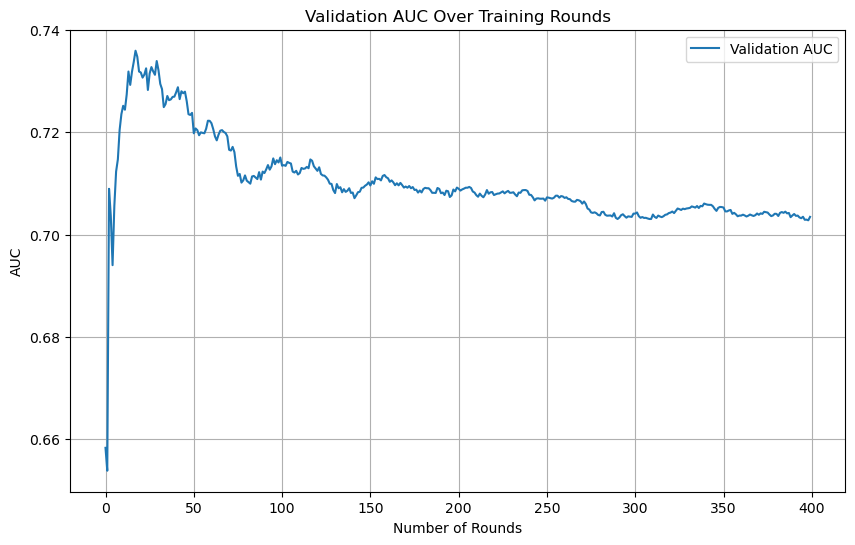

In [58]:
evals_result = final_xgb_clf.evals_result()

# Extract the AUC values for the validation set
auc_values = evals_result['validation_0']['auc']

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.plot(auc_values, label='Validation AUC')
plt.xlabel('Number of Rounds')
plt.ylabel('AUC')
plt.title('Validation AUC Over Training Rounds')
plt.legend()
plt.grid()
plt.show()

In [60]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

def evaluate_model(y_test, y_pred, y_pred_proba):
    """
    Evaluate and print the model's performance metrics.
    
    Args:
        y_test (array-like): True labels.
        y_pred (array-like): Predicted labels.
        y_pred_proba (array-like): Predicted probabilities for the positive class.
    """
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    print("\nModel Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")
    print(f"AUC-ROC Score: {auc_roc:.2%}")



In [62]:
evaluation_results = evaluate_model(y_test_encoded, y_pred_final, y_pred_proba_final)



Model Evaluation Metrics:
Accuracy: 70.33%
Precision: 74.13%
Recall: 84.84%
F1 Score: 79.12%
AUC-ROC Score: 70.35%
